# Weight Minimization Monte Carlo DIS fit 

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split

import optax
from flax.training.early_stopping import EarlyStopping

import jax
import jax.numpy as jnp

from validphys.api import API
from validphys.fkparser import load_fktable
from validphys.loader import Loader
from validphys import convolution
from validphys.convolution import evolution

from colibri.data_batch import DataBatch
from colibri.core import NewDataGroupSpec

In [2]:
DIS_datasets = [{'dataset': 'NMCPD_dw_ite'}, {'dataset': 'SLACP_dwsh'},
                      {'dataset': 'SLACD_dw_ite'}, {'dataset': 'BCDMSP_dwsh'},
                      {'dataset': 'BCDMSD_dw_ite'}, {'dataset': 'CHORUSNUPb_dw_ite'},
               {'dataset': 'CHORUSNBPb_dw_ite'}, {'dataset': 'NTVNUDMNFe_dw_ite', 'cfac': ['MAS']},
               {'dataset': 'HERACOMBNCEM'}, {'dataset': 'HERACOMBNCEP575'}, 
               {'dataset': 'HERACOMBNCEP820'}, {'dataset': 'HERACOMBNCEP920'}, 
               {'dataset': 'HERACOMBCCEP'}, {'dataset': 'HERACOMB_SIGMARED_C'},
               {'dataset': 'HERACOMBCCEM'}, {'dataset': 'HERACOMBNCEP460'},
               {'dataset':'HERACOMB_SIGMARED_B'}, {'dataset':'NMC'}, 
               {'dataset': 'NTVNBDMNFe_dw_ite', 'cfac': ['MAS']}]


inp = {
    "fit": "210713-n3fit-001",
    "dataset_inputs": DIS_datasets,
    "use_cuts": "internal",
    "theoryid": 400
}
data = API.data(**inp)

In [3]:
Ndat = sum([cd.ndata for cd in data.load_commondata_instance()])

def len_training_set(Ndat, test_size, random_state):
    idx_train, idx_test = train_test_split(jnp.arange(Ndat), test_size=test_size, random_state=random_state)
    return len(idx_train), len(idx_test)
test_size=0.2
random_state=42
N_train, N_test = len_training_set(Ndat, test_size, random_state)

new_data = NewDataGroupSpec(name = "data", datasets = data.datasets, dsinputs = data.dsinputs)

2023-06-15 09:09:54.355816: E external/org_tensorflow/tensorflow/compiler/xla/python/pjit.cc:606] fastpath_data is none
2023-06-15 09:09:54.405595: E external/org_tensorflow/tensorflow/compiler/xla/python/pjit.cc:606] fastpath_data is none


In [4]:
# Random Initial Weights
l = Loader()
pdf = l.check_pdf("210713-n3fit-001")

# shape (101, 14, 50)
# LinearBasis Class - > implements basis transformation from flavour to any?
# grid_values: Evaluate ``x*f(x)`` on a grid of points in flavour, x and Q.

xgrid = load_fktable(data.datasets[0].fkspecs[0]).xgrid

INPUT_GRID = evolution.grid_values(pdf, convolution.FK_FLAVOURS, xgrid, [1.65]).squeeze(-1)
rng = jax.random.PRNGKey(0xDEADBEEF)
# initial weights for weight minimization
weight_base_num = jax.random.normal(rng, shape=(INPUT_GRID.shape[0],))
weight_base = weight_base_num/jnp.sum(weight_base_num)


# chi2_contribs_data_mini_batch = new_data.make_chi2_data_mini_batch(train_val_split=True, test_size=test_size, random_state=random_state)

# chi2_validation = new_data.make_chi2_validation(test_size=test_size, random_state=random_state)



LHAPDF 6.5.0 loading all 101 PDFs in set 210713-n3fit-001
210713-n3fit-001, version 1; 101 PDF members


In [5]:
N_replica = 10
nr_epochs = 2000
patience = 2

batch_size = 128
databatch = DataBatch(Ndat=N_train,batch_size=batch_size,seed=0)
batches = databatch.data_batch_stream_index()
num_batches = databatch.num_batches()

initial_params = weight_base
nr_epochs = 2000


replica_parameters = []

for rep in range(N_replica):
    filterseed = np.random.randint(1000000)
    replicate=True
#     if rep == 0:
#         replicate=False

    chi2_contribs_data_mini_batch = new_data.make_chi2_data_mini_batch(train_val_split=True, test_size=test_size, random_state=random_state, replicate=replicate, filterseed=filterseed)

    chi2_validation = new_data.make_chi2_validation(test_size=test_size, random_state=random_state, replicate=replicate, filterseed=filterseed)
    
    @jax.jit
    def loss_data_batch(weights,batch_idx):
        pdf = jnp.einsum("i,ijk", weights, INPUT_GRID)
        return chi2_contribs_data_mini_batch(pdf,batch_idx)

    @jax.jit
    def loss_validation(weights):
        pdf = jnp.einsum("i,ijk", weights, INPUT_GRID)
        return chi2_validation(pdf)


    print("######################################################")
    print(f"Fitting Replica Number {rep}")
    def fit(nr_epochs: int, num_batches, batches, batch_size, params: optax.Params, optimizer: optax.GradientTransformation) -> optax.Params:
        """"""
        opt_state = optimizer.init(params)

        @jax.jit
        def step(params,opt_state,batch_idx):
            loss_value, grads = jax.value_and_grad(loss_data_batch)(params,batch_idx)
            updates, opt_state = optimizer.update(grads,opt_state,params)
            params = optax.apply_updates(params,updates)
            return params, opt_state, loss_value

        loss = []
        val_loss = []

        early_stop = EarlyStopping(min_delta=1e-4, patience=patience)

        for i in range(nr_epochs):

            epoch_loss = 0
            epoch_val_loss = 0

            for _ in range(num_batches):
                batch = next(batches)
                params, opt_state, loss_value = step(params, opt_state, batch)
                epoch_loss+=loss_value / batch_size

            epoch_loss /= num_batches

            loss.append(epoch_loss)
            epoch_val_loss += loss_validation(params) / (N_test)
            val_loss.append(epoch_val_loss)        


            if i % 100 == 0:

                print(f'step {i}, loss: {epoch_loss:.3f}, validation_loss: {epoch_val_loss:.3f}')        


                _, early_stop = early_stop.update(epoch_val_loss)
                print(f"epoch:{i}, early_stop: {early_stop}")

                if early_stop.should_stop:
                    print('Met early stopping criteria, breaking...')
                    break

        return params, loss, val_loss
    
    optimizer = optax.adam(learning_rate=5e-4)
    params, loss, val_loss = fit(nr_epochs, num_batches, batches, batch_size, initial_params, optimizer)
    
    replica_parameters.append(params)

######################################################
Fitting Replica Number 0


2023-06-15 09:10:51.135380: E external/org_tensorflow/tensorflow/compiler/xla/python/pjit.cc:606] fastpath_data is none


step 0, loss: 2.236, validation_loss: 2.358
epoch:0, early_stop: EarlyStopping(min_delta=0.0001, patience=2, best_metric=Array(2.3578336, dtype=float32), patience_count=0, should_stop=False)
step 100, loss: 2.133, validation_loss: 2.279
epoch:100, early_stop: EarlyStopping(min_delta=0.0001, patience=2, best_metric=Array(2.2792878, dtype=float32), patience_count=0, should_stop=False)
step 200, loss: 2.094, validation_loss: 2.277
epoch:200, early_stop: EarlyStopping(min_delta=0.0001, patience=2, best_metric=Array(2.2766504, dtype=float32), patience_count=0, should_stop=False)
step 300, loss: 2.071, validation_loss: 2.289
epoch:300, early_stop: EarlyStopping(min_delta=0.0001, patience=2, best_metric=Array(2.2766504, dtype=float32), patience_count=1, should_stop=False)
step 400, loss: 2.094, validation_loss: 2.285
epoch:400, early_stop: EarlyStopping(min_delta=0.0001, patience=2, best_metric=Array(2.2766504, dtype=float32), patience_count=2, should_stop=False)
step 500, loss: 2.109, valida

step 600, loss: 2.112, validation_loss: 2.134
epoch:600, early_stop: EarlyStopping(min_delta=0.0001, patience=2, best_metric=Array(2.1264822, dtype=float32), patience_count=2, should_stop=False)
step 700, loss: 2.112, validation_loss: 2.129
epoch:700, early_stop: EarlyStopping(min_delta=0.0001, patience=2, best_metric=Array(2.1264822, dtype=float32), patience_count=3, should_stop=True)
Met early stopping criteria, breaking...
######################################################
Fitting Replica Number 4
step 0, loss: 2.169, validation_loss: 2.114
epoch:0, early_stop: EarlyStopping(min_delta=0.0001, patience=2, best_metric=Array(2.1137831, dtype=float32), patience_count=0, should_stop=False)
step 100, loss: 2.109, validation_loss: 2.096
epoch:100, early_stop: EarlyStopping(min_delta=0.0001, patience=2, best_metric=Array(2.0959058, dtype=float32), patience_count=0, should_stop=False)
step 200, loss: 2.107, validation_loss: 2.082
epoch:200, early_stop: EarlyStopping(min_delta=0.0001, pat

step 800, loss: 2.033, validation_loss: 2.078
epoch:800, early_stop: EarlyStopping(min_delta=0.0001, patience=2, best_metric=Array(2.0607674, dtype=float32), patience_count=1, should_stop=False)
step 900, loss: 2.004, validation_loss: 2.066
epoch:900, early_stop: EarlyStopping(min_delta=0.0001, patience=2, best_metric=Array(2.0607674, dtype=float32), patience_count=2, should_stop=False)
step 1000, loss: 2.056, validation_loss: 2.066
epoch:1000, early_stop: EarlyStopping(min_delta=0.0001, patience=2, best_metric=Array(2.0607674, dtype=float32), patience_count=3, should_stop=True)
Met early stopping criteria, breaking...
######################################################
Fitting Replica Number 8
step 0, loss: 2.228, validation_loss: 2.175
epoch:0, early_stop: EarlyStopping(min_delta=0.0001, patience=2, best_metric=Array(2.1745648, dtype=float32), patience_count=0, should_stop=False)
step 100, loss: 2.129, validation_loss: 2.177
epoch:100, early_stop: EarlyStopping(min_delta=0.0001, p

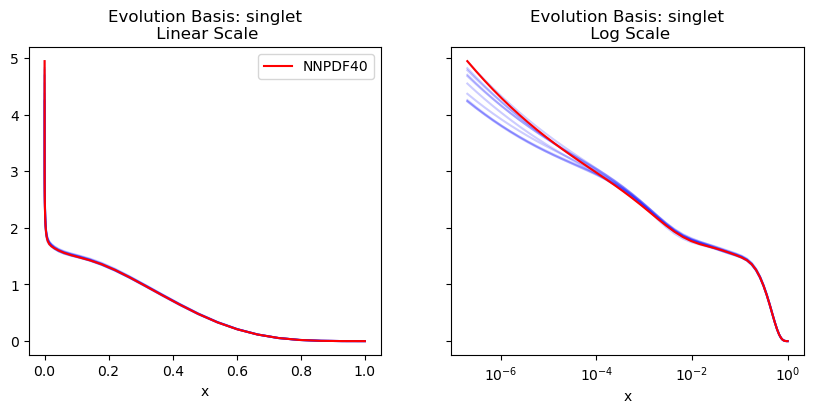

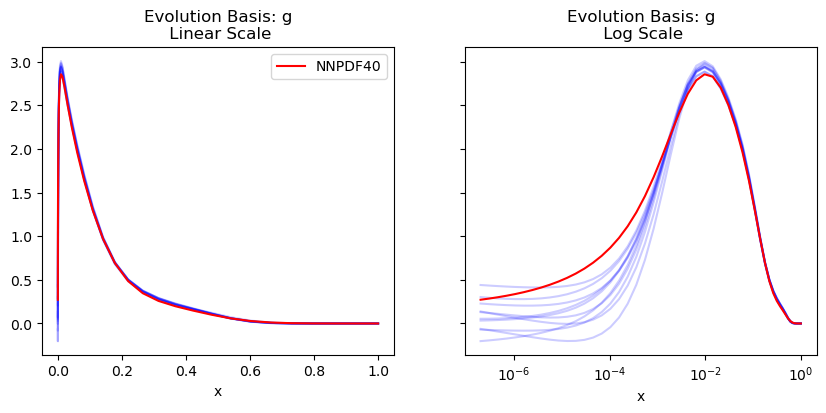

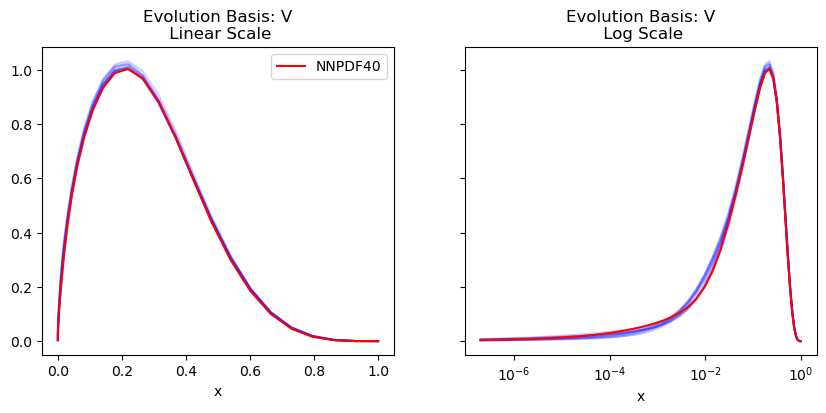

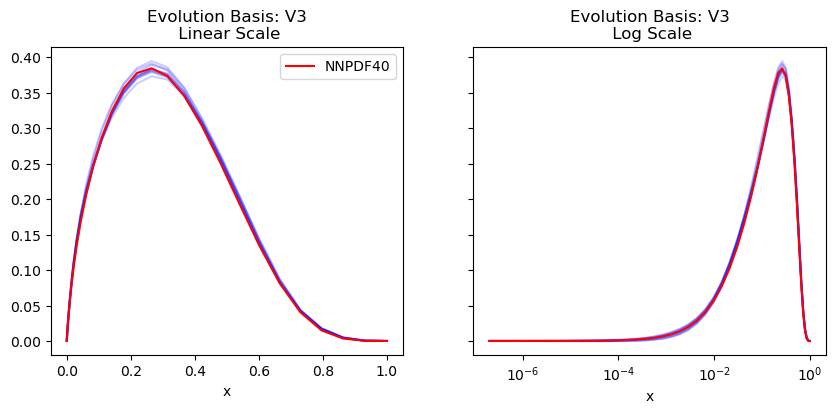

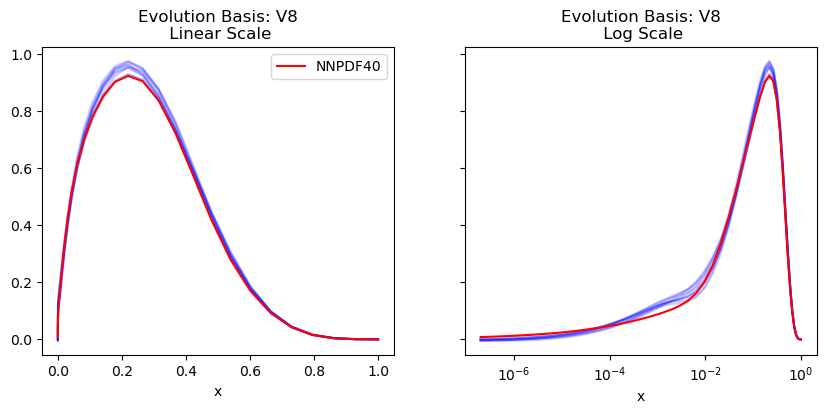

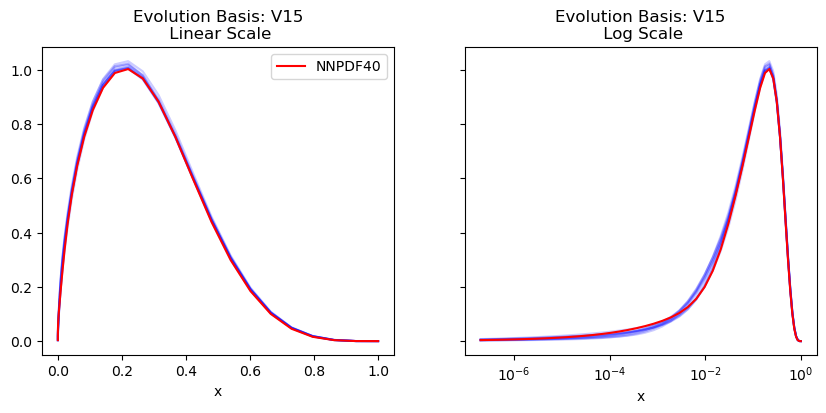

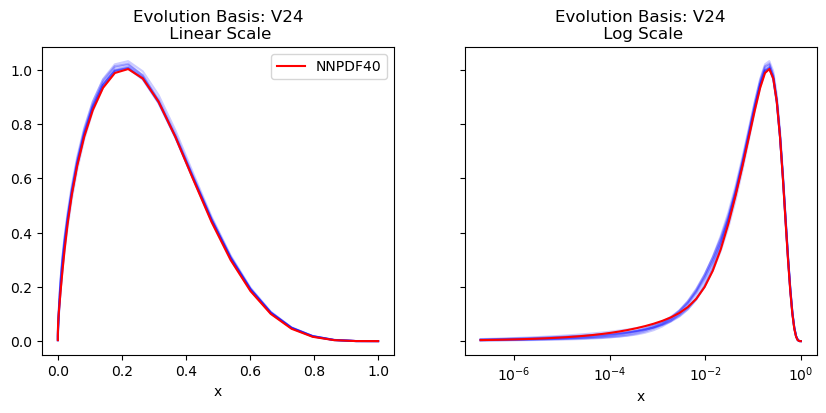

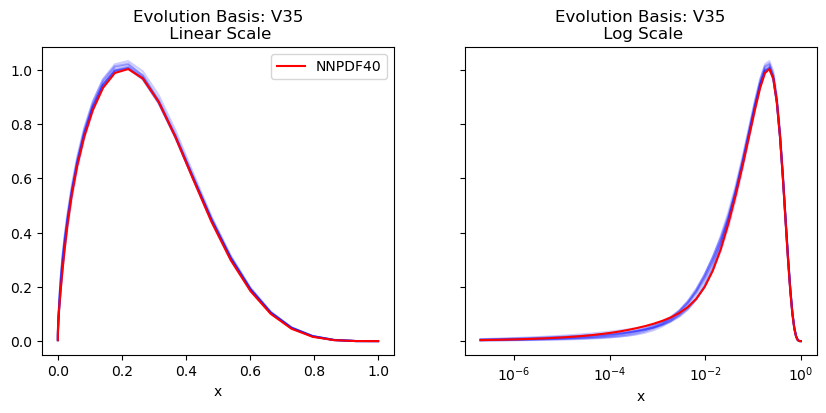

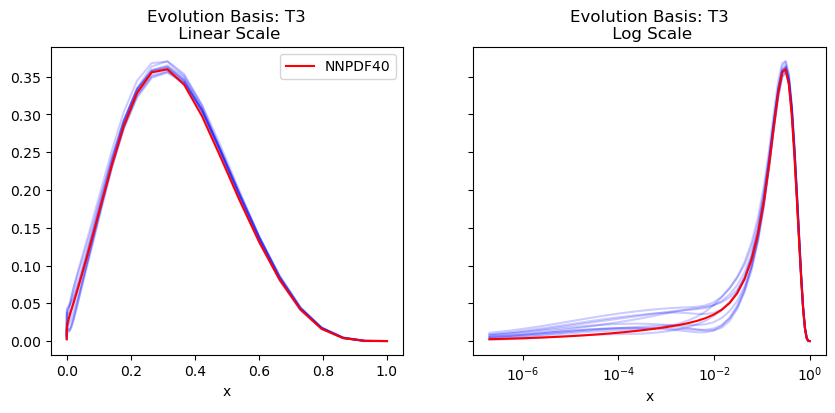

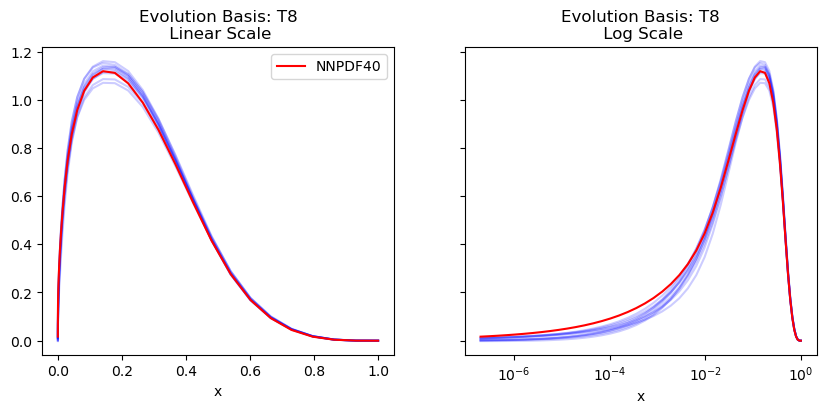

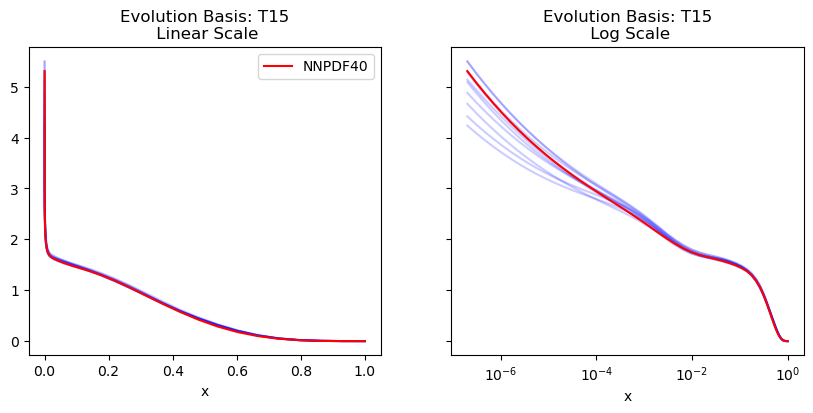

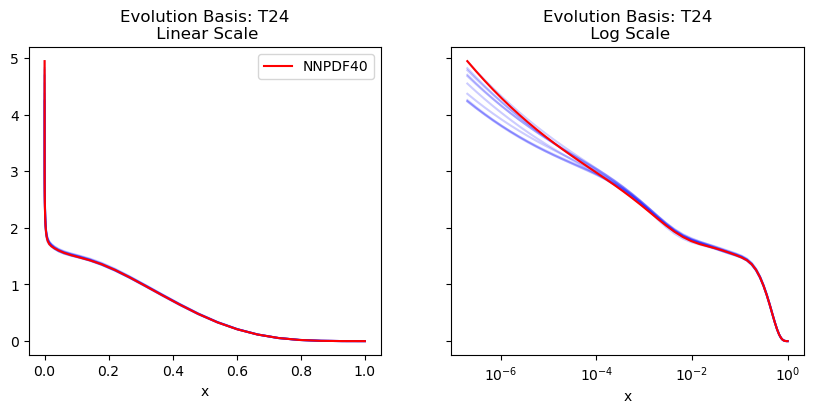

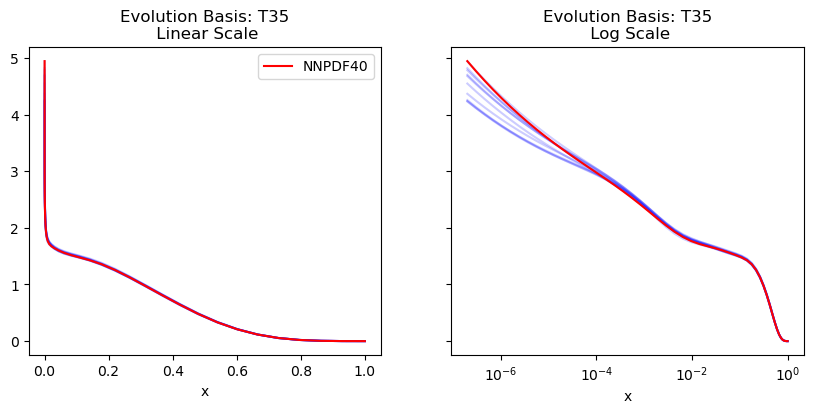

In [50]:
import matplotlib.pyplot as plt

ev_basis = ["photon","singlet", "g", "V", "V3", "V8","V15","V24","V35","T3","T8","T15","T24","T35",]

for n in range(1,len(ev_basis)):


    fig, axs = plt.subplots(1,2, sharey=True, figsize=(10,4))

    for params in replica_parameters:
        axs[0].plot(xgrid ,jnp.einsum("i,ijk->jk", params, INPUT_GRID)[n, :], alpha=0.2, color='b')
        axs[1].plot(xgrid ,jnp.einsum("i,ijk->jk", params, INPUT_GRID)[n, :], alpha=0.2, color='b')
    
    axs[1].set_xscale('log')
    
    axs[0].plot(xgrid, INPUT_GRID[0, n,:], label = 'NNPDF40', color = 'r')
    axs[1].plot(xgrid, INPUT_GRID[0, n,:], label = 'NNPDF40', color = 'r')
    
    axs[0].legend()
    axs[0].set_title(f"Evolution Basis: {ev_basis[n]}\n Linear Scale")
    axs[1].set_title(f"Evolution Basis: {ev_basis[n]}\n Log Scale")
    axs[0].set_xlabel('x')
    axs[1].set_xlabel('x')

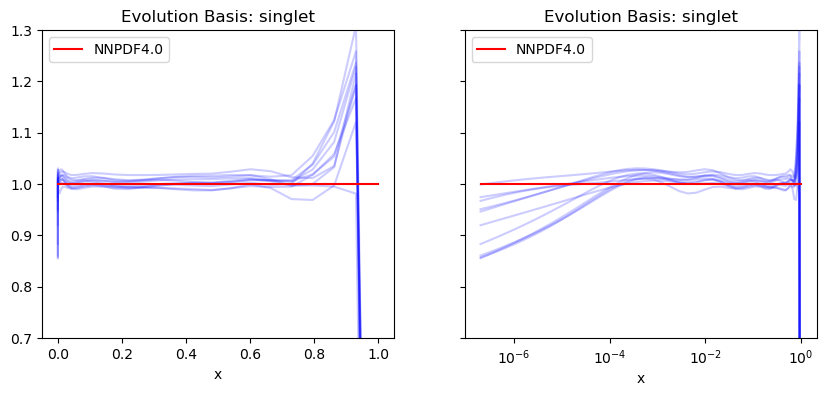

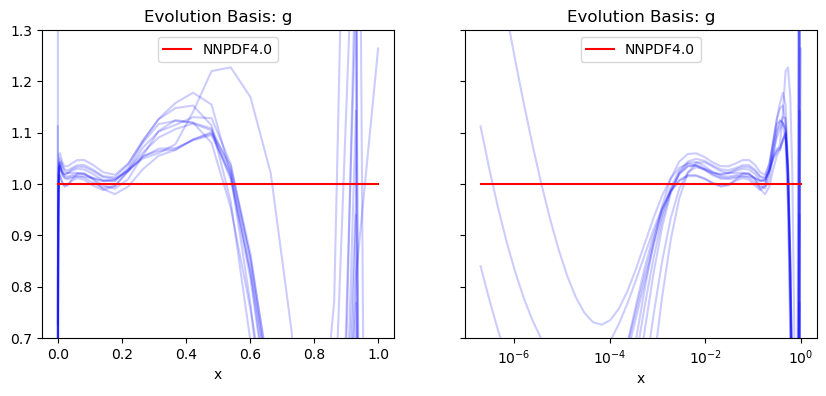

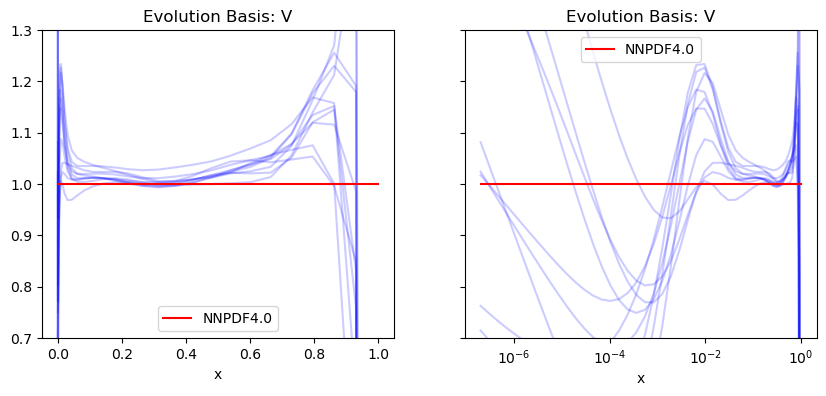

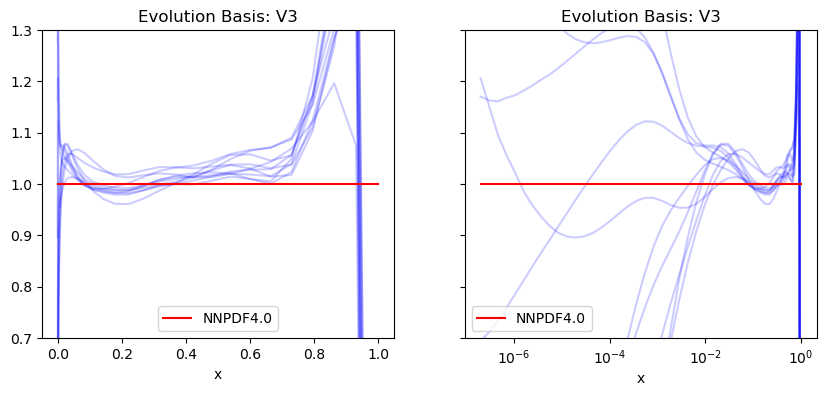

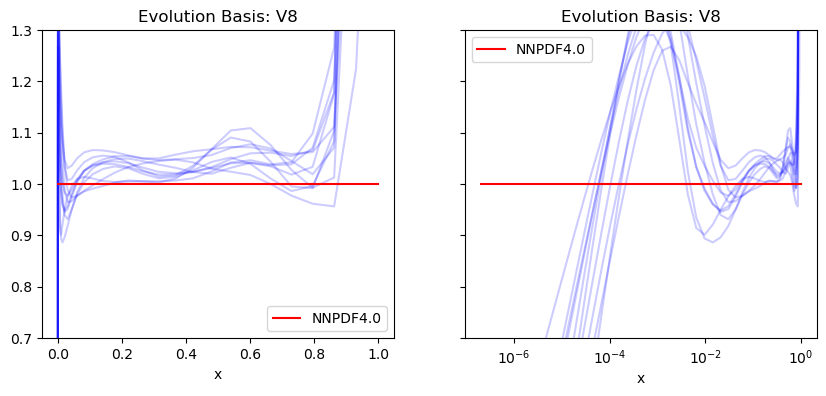

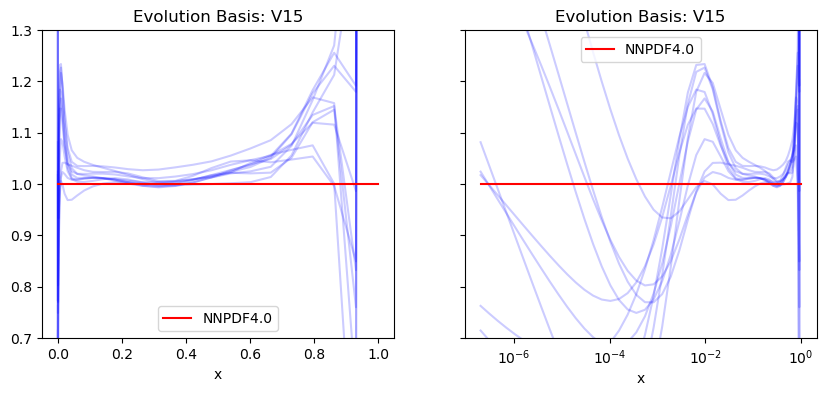

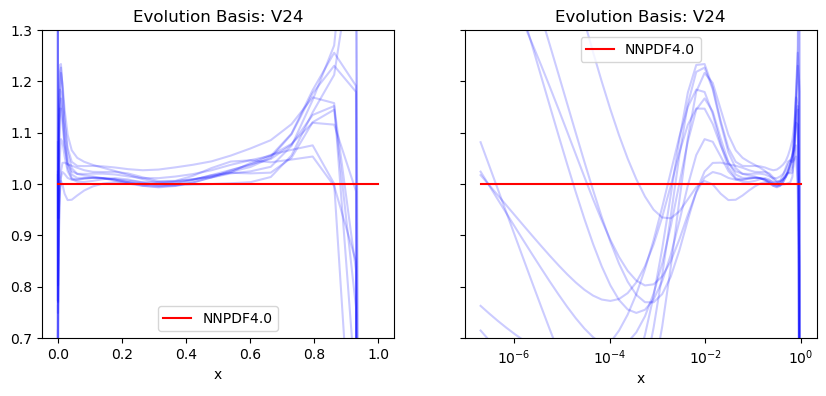

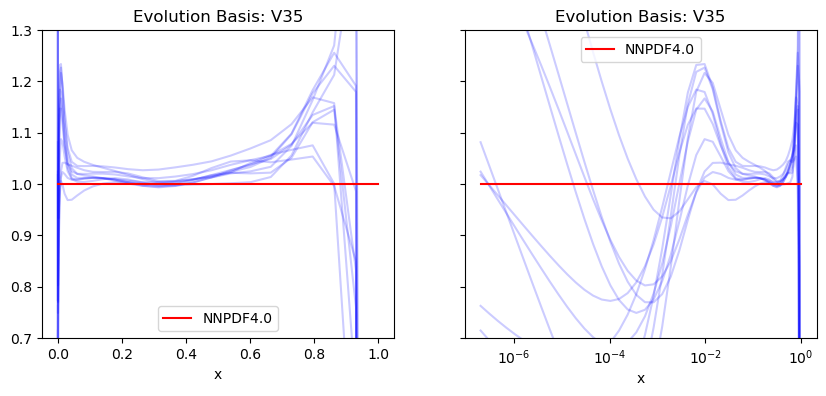

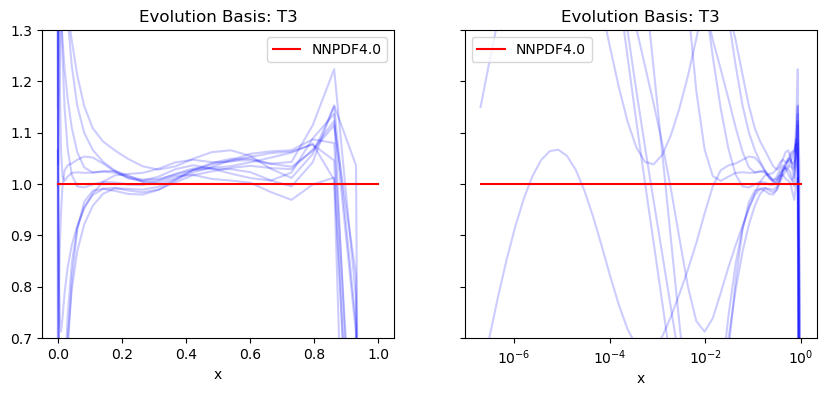

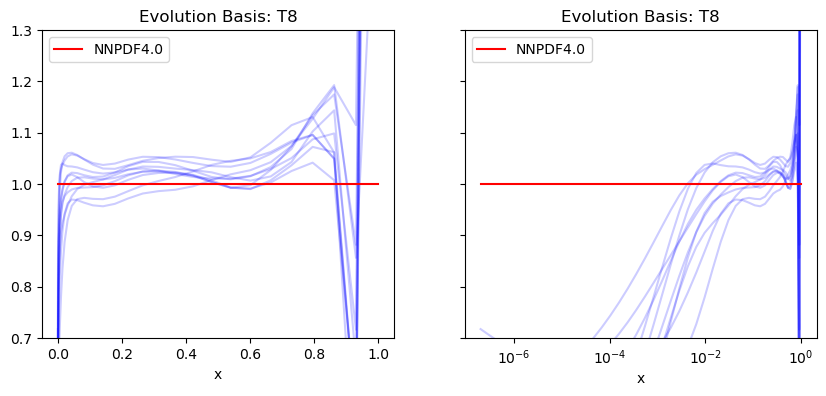

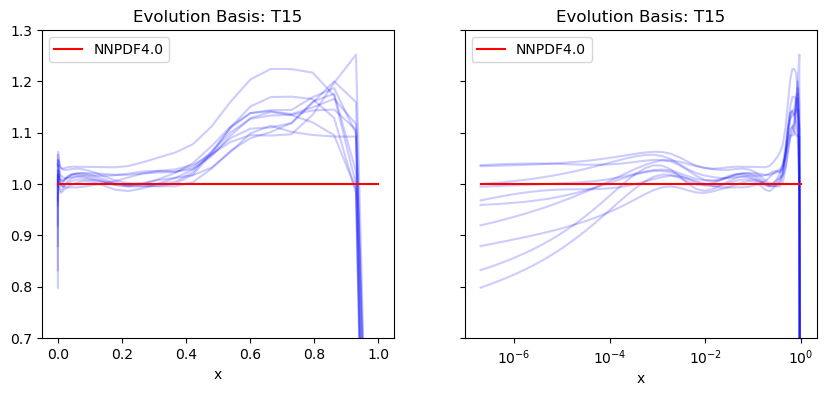

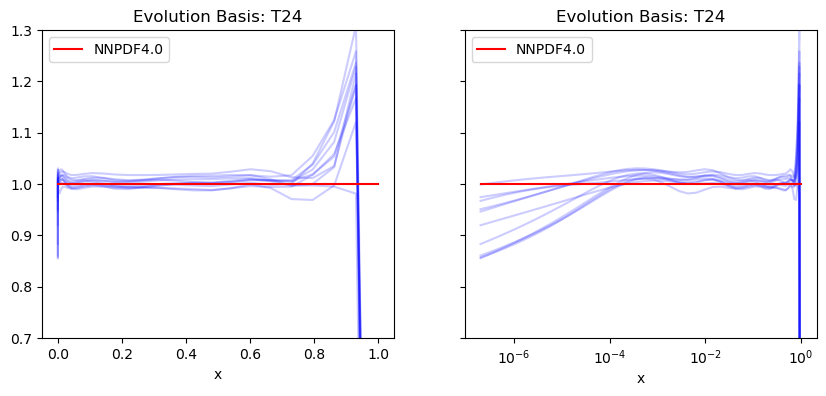

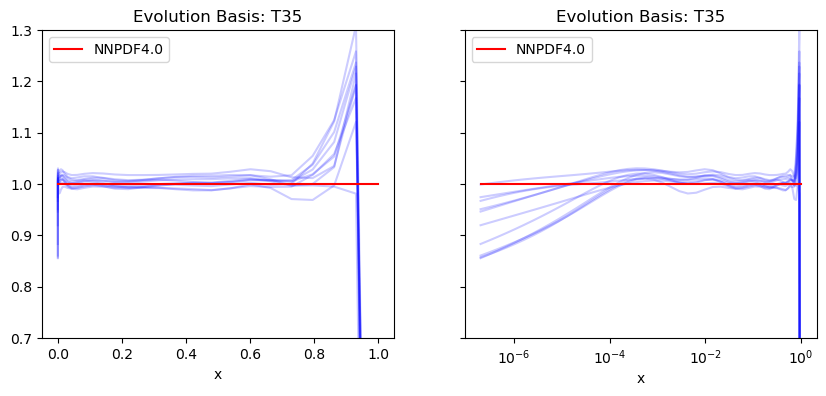

In [51]:
n=0
ev_basis = ["photon","singlet", "g", "V", "V3", "V8","V15","V24","V35","T3","T8","T15","T24","T35",]
for n in range(1,len(ev_basis)):
    
    fig, axs = plt.subplots(1,2, figsize=(10,4), sharey=True)

    for params in replica_parameters:
        axs[0].plot(xgrid,jnp.einsum("i,ijk->jk", params, INPUT_GRID)[n, :] / INPUT_GRID[0, n,:], alpha=0.2, color='b',)
        axs[1].plot(xgrid,jnp.einsum("i,ijk->jk", params, INPUT_GRID)[n, :] / INPUT_GRID[0, n,:], alpha=0.2, color='b',)
    
    axs[1].set_xscale('log')
    axs[0].plot(xgrid, INPUT_GRID[0, n,:] /INPUT_GRID[0, n,:], color='r', label = 'NNPDF4.0')
    axs[1].plot(xgrid, INPUT_GRID[0, n,:] /INPUT_GRID[0, n,:], color='r', label = 'NNPDF4.0')
    
    axs[0].set_xlabel('x')
    axs[1].set_xlabel('x')

    # ax.plot(INPUT_GRID[0, n,:], label = 'NNPDF40', color = 'r')
    axs[0].legend()
    axs[1].legend()
    axs[0].set_title(f"Evolution Basis: {ev_basis[n]}")
    axs[1].set_title(f"Evolution Basis: {ev_basis[n]}")
    axs[0].set_ylim(0.7,1.3)